## Time Series Forecasting Using Pyro

In [60]:
%reset -sf

In [61]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
from pyro.contrib.autoguide import *
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

### Lynx Dataset

In [62]:
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx = pd.read_csv(URL, index_col=0)
lynx[:20]

,time,value
1,1821,269
2,1822,321
3,1823,585
4,1824,871
5,1825,1475
6,1826,2821
7,1827,3928
8,1828,5943
9,1829,4950
10,1830,2577


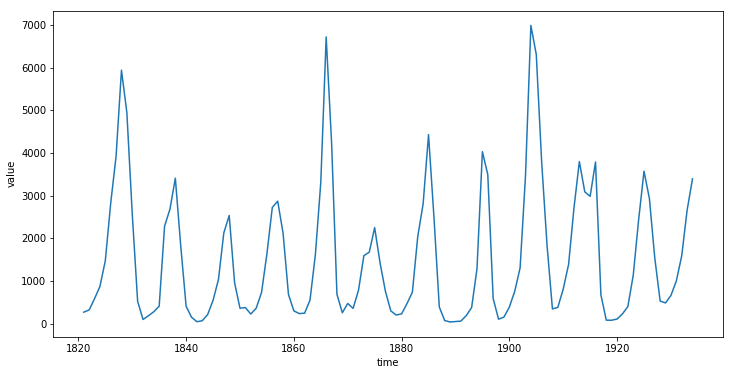

In [63]:
y = torch.tensor(lynx["value"].values, dtype=torch.float32)
y_train = y[:-30]
sns.lineplot('time', 'value', data=lynx);

### Model 1: Model based on SGT (Seasonal Global Trend)

In [64]:
def get_seasonality_lookup_idx(num_observed, S, idx):
    """
    Based on the the seasonality `S` and number of observed data points,
    return the index of the last observed data point that is one or more 
    seasons away from idx.
    
    e.g. 
    
    S=5, num_observed=11, idx=12, return -> 7
    S=5, num_observed=11, idx=18, return -> 8
    """
    if idx < S:
        return idx
    lookback = 1
    window_start = (int(idx / S) - lookback) * S
    lookup_idx = window_start + idx % S
    while lookup_idx >= num_observed:
        lookback = lookback + 1
        window_start = (int(idx / S) - lookback) * S
        lookup_idx = window_start + idx % S
    return lookup_idx

In [65]:
def model_sgt_1(y, seasonality, predict_ahead=0):
    """
    A bayesian model for time series forecasting using Seasonal Global Trend (SGT).
    """
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    alpha = pyro.sample('alpha', dist.Beta(1., 1.)) 
    beta = pyro.sample('beta', dist.Beta(1., 1.))
    gamma = pyro.sample('gamma', dist.Beta(1., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Normal(0., 0.5))
    s = [torch.tensor(1.)] * len(y)
    l = [torch.tensor(0.)] * len(y)
    l[0] = y[0]
    y_hat = torch.zeros(len(y))
    y_hat[0] = y[0]
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert s[i] > 0
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert l[i] > 0, "alpha: {}".format(alpha)
        s[i] = gamma * (y[i] / l[i]) + (1 - gamma) * s_i
        y_hat[i] = (l[i - 1] + beta * l[i - 1] ** pow_trend) * s_i 
        
    pyro.sample('y', dist.StudentT(nu, y_hat, sigma), obs=y)
        
    if predict_ahead > 0:
        y_pred = torch.zeros(predict_ahead)
        for j in range(predict_ahead):
            i = len(y) + j
            s_i = s[get_seasonality_lookup_idx(len(y), S, i)]
            l_i = l[len(y) - 1]
            y_pred[j] = (l_i + j * beta * l_i ** pow_trend) * s_i
        pyro.sample('s', dist.Delta(torch.stack(s)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l)))  # For plotting
        pyro.sample('y_pred', dist.StudentT(nu, y_pred, sigma))

In [66]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide = AutoDiagonalNormal(model_sgt_1)
opt = optim.Adam({'lr': 0.05})

svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())
S = 10  # Use seasonality of 10

for i in range(800):
    loss = svi.step(y_train, S)
    if i % 50 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 847.3301115036011
ELBO loss: 734.3508081436157
ELBO loss: 709.1015923023224
ELBO loss: 720.7009398937225
ELBO loss: 706.1514331102371
ELBO loss: 718.1254436373711
ELBO loss: 707.2442800998688
ELBO loss: 707.2141666412354
ELBO loss: 707.2520081996918
ELBO loss: 702.7255110740662
ELBO loss: 706.6365929245949
ELBO loss: 714.0526897907257
ELBO loss: 706.6044012308121
ELBO loss: 709.779572725296
ELBO loss: 707.2580708265305
ELBO loss: 708.593324303627
ELBO loss: 706.6338075399399


In [67]:
def predict(model, guide, y, *args, future_steps=30, num_samples=100):
    """
    Generate `num_samples` predictions by sampling the parameters for the
    time series model from the approximate posterior.    
    """
    preds = []
    l, s = [], []
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(y, *args, predict_ahead=future_steps)
        model_trace = poutine.trace(poutine.replay(model, guide_trace)).get_trace(y, *args, 
                                                                                  predict_ahead=future_steps)
        preds.append(torch.cat([model_trace.nodes['y']['value'], model_trace.nodes['y_pred']['value']]))
        l.append(model_trace.nodes['l']['value'])
        s.append(model_trace.nodes['s']['value'])
    return torch.stack(preds), torch.stack(l), torch.stack(s)

In [68]:
num_samples = 500
preds, l, s = predict(model_sgt_1, guide, y_train, S, future_steps=60, num_samples=num_samples)

In [69]:
res1 = lynx.copy()
res1['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res1 = res1.append(df, sort=True)
res1 = res1.astype({'time': 'int32'})

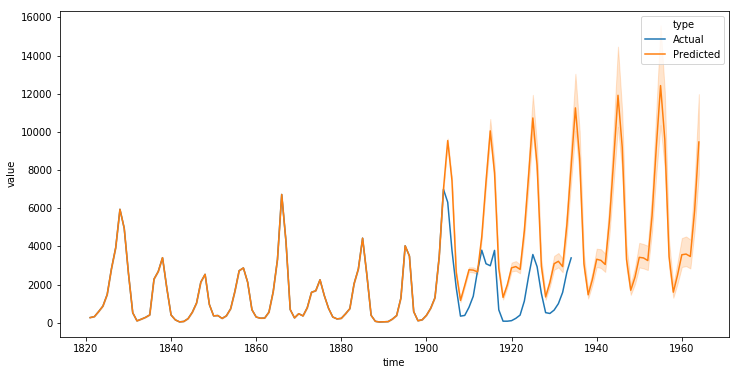

In [70]:
sns.lineplot('time', 'value', data=res1, hue='type');

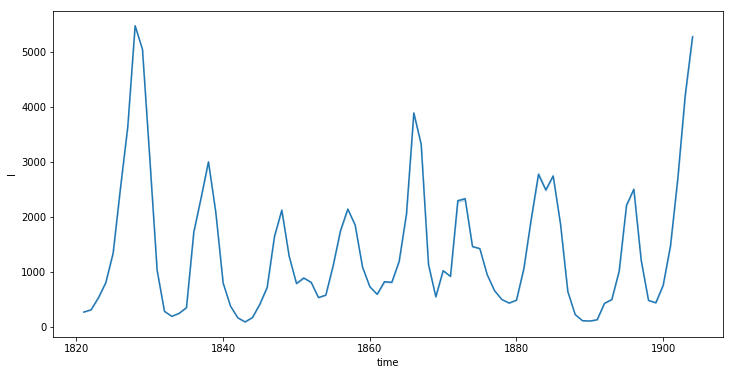

In [71]:
sns.lineplot('time', 'l', data=res1);

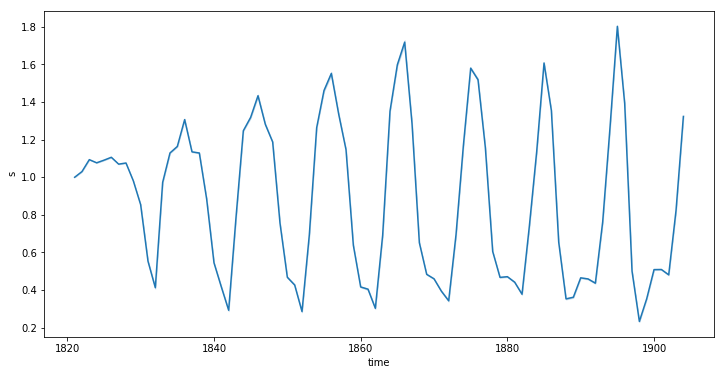

In [72]:
sns.lineplot('time', 's', data=res1);

### Model dual seasonality (use the higher S=38)

In [73]:
pyro.clear_param_store()

S = 38
guide = AutoDiagonalNormal(model_sgt_1)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())

for i in range(800):
    loss = svi.step(y_train, S)
    if i % 50 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))        

ELBO loss: 1086.5868203639984
ELBO loss: 770.0501327514648
ELBO loss: 734.7222590446472
ELBO loss: 730.2898044586182
ELBO loss: 720.8832476139069
ELBO loss: 720.0759429335594
ELBO loss: 721.1504096984863
ELBO loss: 726.0093070864677
ELBO loss: 718.9085204601288
ELBO loss: 720.0367623567581
ELBO loss: 718.3385580182076
ELBO loss: 722.7845810651779
ELBO loss: 725.6609846353531
ELBO loss: 722.349625825882
ELBO loss: 721.0566244125366
ELBO loss: 719.3994709253311
ELBO loss: 715.4001904726028


In [74]:
num_samples = 100
preds, l, s = predict(model_sgt_1, guide, y_train, S, future_steps=60, num_samples=num_samples)

res3 = lynx.copy()
res3['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res3 = res3.append(df, sort=True)
res3 = res3.astype({'time': 'int32'})

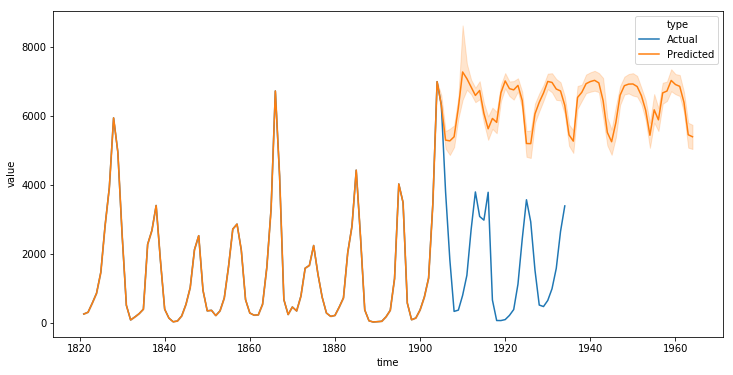

In [75]:
sns.lineplot('time', 'value', data=res3, hue='type');

## Model 1.1: Change prior to smooth non-seasonal component

In [76]:
def model_sgt_2(y, seasonality, predict_ahead=0):
    """
    A bayesian model for Seasonal Global Trend (SGT).
    """
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    # NOTE: prior is changed to bias alpha --> 0.
    alpha = pyro.sample('alpha', dist.Beta(1., 10.)) 
    beta = pyro.sample('beta', dist.Beta(1., 1.))
    gamma = pyro.sample('gamma', dist.Beta(1., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Normal(0., 0.5))
    s = [torch.tensor(1.)] * len(y)
    l = [torch.tensor(0.)] * len(y)
    l[0] = y[0]
    y_hat = torch.zeros(len(y))
    y_hat[0] = y[0]
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert s[i] > 0
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert l[i] > 0, "alpha: {}".format(alpha)
        s[i] = gamma * (y[i] / l[i]) + (1 - gamma) * s_i
        y_hat[i] = (l[i - 1] + beta * l[i - 1] ** pow_trend) * s_i 
        
    pyro.sample('y', dist.StudentT(nu, y_hat, sigma), obs=y)
        
    if predict_ahead > 0:
        y_pred = torch.zeros(predict_ahead)
        for j in range(predict_ahead):
            i = len(y) + j
            s_i = s[get_seasonality_lookup_idx(len(y), S, i)]
            l_i = l[len(y) - 1]
            y_pred[j] = (l_i + j * beta * l_i ** pow_trend) * s_i
        pyro.sample('s', dist.Delta(torch.stack(s)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l)))  # For plotting
        pyro.sample('y_pred', dist.StudentT(nu, y_pred, sigma))

In [77]:
pyro.clear_param_store()

S = 38
guide = AutoDiagonalNormal(model_sgt_2)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_2, guide, opt, loss=Trace_ELBO())

for i in range(800):
    loss = svi.step(y_train, S)
    if i % 50 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 1652.212327837944
ELBO loss: 747.3644868135452
ELBO loss: 728.4590672850609
ELBO loss: 730.2385387420654
ELBO loss: 729.1003069877625
ELBO loss: 731.1391735076904
ELBO loss: 730.2849985361099
ELBO loss: 725.7636480331421
ELBO loss: 730.4308886528015
ELBO loss: 729.1736183166504
ELBO loss: 729.6569361686707
ELBO loss: 729.2449587583542
ELBO loss: 727.2907557487488
ELBO loss: 734.3212087154388
ELBO loss: 731.8593819141388
ELBO loss: 726.5904424190521
ELBO loss: 726.2037463784218


In [78]:
num_samples = 100
preds, l, s = predict(model_sgt_2, guide, y_train, S, future_steps=60, num_samples=num_samples)

res2 = lynx.copy()
res2['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res2 = res2.append(df, sort=True)
res2 = res2.astype({'time': 'int32'})

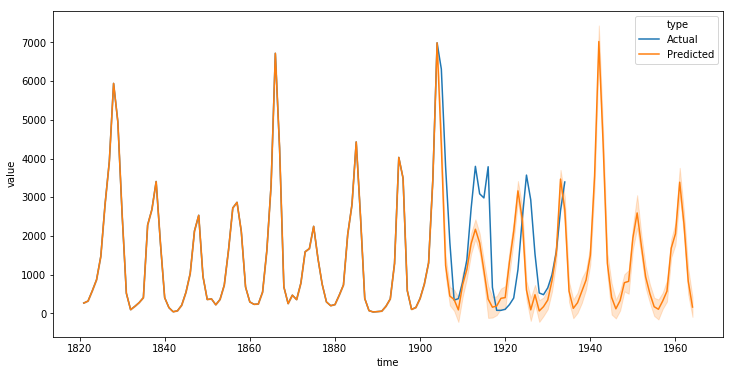

In [79]:
sns.lineplot('time', 'value', data=res2, hue='type');

## Model 2: let the variance also depend on the value of the time series

In [80]:
def model_sgt_3(y, seasonality, predict_ahead=0):
    """
    A bayesian model for Seasonal Global Trend (SGT).
    """
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    # NOTE: prior is changed to bias alpha --> 0.
    alpha = pyro.sample('alpha', dist.Beta(1., 10.)) 
    beta = pyro.sample('beta', dist.Beta(1., 1.))
    gamma = pyro.sample('gamma', dist.Beta(1., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Normal(0., 0.1))
    pow_var = pyro.sample('pow_var', dist.Normal(0., 1.))
    s = [torch.tensor(1.)] * len(y)
    l = [torch.tensor(0.)] * len(y)
    l[0] = y[0]
    y_hat = torch.zeros(len(y))
    y_hat[0] = y[0]
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert s[i] > 0
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert l[i] > 0, "alpha: {}".format(alpha)
        s[i] = gamma * (y[i] / l[i]) + (1 - gamma) * s_i
        y_hat[i] = (l[i - 1] + beta * l[i - 1] ** pow_trend) * s_i 
        
    sigma_hat = sigma * y_hat ** pow_var
    pyro.sample('y', dist.StudentT(nu, y_hat, sigma_hat), obs=y)
        
    if predict_ahead > 0:
        y_pred = torch.zeros(predict_ahead)
        for j in range(predict_ahead):
            i = len(y) + j
            s_i = s[get_seasonality_lookup_idx(len(y), S, i)]
            l_i = l[len(y) - 1]
            y_pred[j] = (l_i + j * beta * l_i ** pow_trend) * s_i
        pyro.sample('s', dist.Delta(torch.stack(s)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l)))  # For plotting
        sigma_hat = sigma * y_pred ** pow_var
        pyro.sample('y_pred', dist.StudentT(nu, y_pred, sigma_hat))

In [81]:
pyro.clear_param_store()

S = 38
guide = AutoDiagonalNormal(model_sgt_3)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_3, guide, opt, loss=Trace_ELBO())

for i in range(1000):
    loss = svi.step(y_train, S)
    if i % 50 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 7665.2307035923
ELBO loss: 1512.639251947403
ELBO loss: 1102.0412100553513
ELBO loss: 779.909875869751
ELBO loss: 785.9051800966263
ELBO loss: 743.4549787044525
ELBO loss: 831.3713804483414
ELBO loss: 734.2207646369934
ELBO loss: 739.5091361999512
ELBO loss: 732.8783390522003
ELBO loss: 751.6161462664604
ELBO loss: 747.8906173110008
ELBO loss: 730.4196772575378
ELBO loss: 729.4937891960144
ELBO loss: 722.6308060288429
ELBO loss: 719.7409378290176
ELBO loss: 744.9040086269379
ELBO loss: 721.5248383283615
ELBO loss: 733.3116747140884
ELBO loss: 740.5341662168503
ELBO loss: 717.2999361753464


In [82]:
num_samples = 100
preds, l, s = predict(model_sgt_3, guide, y_train, S, future_steps=60, num_samples=num_samples)

res4 = lynx.copy()
res4['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res4 = res4.append(df, sort=True)
res4 = res4.astype({'time': 'int32'})

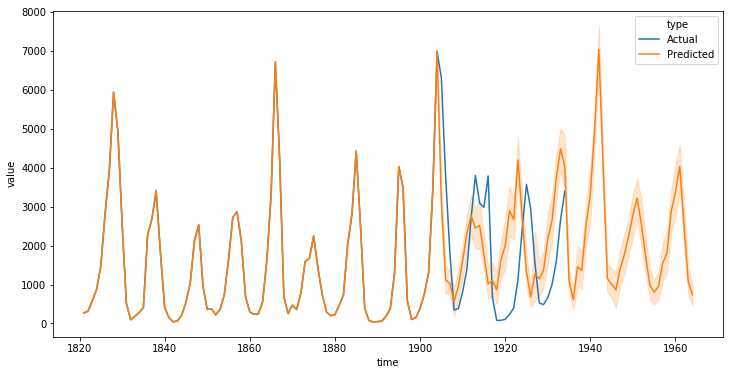

In [83]:
sns.lineplot('time', 'value', data=res4, hue='type');

## Exact inference using MCMC

In [84]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

In [85]:
model = model_sgt_2  # compiling model_sgt_3 takes too long
nuts_kernel = NUTS(model=model, jit_compile=True, ignore_jit_warnings=True)
num_samples = 1000
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_samples)
S = 38
mcmc.run(y_train, S)

sample: 100%|██████████| 2000/2000 [00:35<00:00, 56.24it/s, step size=4.73e-01, acc. prob=0.883]


In [86]:
def predict_mcmc(model, model_samples, y, *args, future_steps=30):
    """
    Generate `num_samples` predictions by sampling the parameters for the
    time series model from the approximate posterior.    
    """
    preds = []
    l, s = [], []
    for i in range(len(model_samples)):
        model_trace = poutine.trace(poutine.condition(model, model_samples)).get_trace(y, *args, 
                                                                                       predict_ahead=future_steps)
        preds.append(torch.cat([model_trace.nodes['y']['value'], model_trace.nodes['y_pred']['value']]))
        l.append(model_trace.nodes['l']['value'])
        s.append(model_trace.nodes['s']['value'])
    return torch.stack(preds), torch.stack(l), torch.stack(s)

In [87]:
samples = mcmc.get_samples()
samples_list = [{k: v[i] for k, v in samples.items()} for i in range(num_samples)]
preds, l, s = predict_mcmc(model, samples_list, y_train, S, future_steps=60)

res5 = lynx.copy()
res5['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res5 = res5.append(df, sort=True)
res5 = res5.astype({'time': 'int32'})

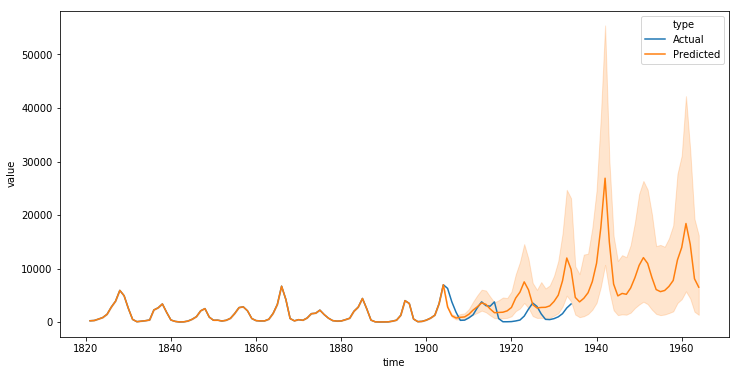

In [88]:
sns.lineplot('time', 'value', data=res5, hue='type');